# Dynamic Programming

The term dynamic programming refers to a collection of algorithms that can be used to **compute optimal policies** for a MDP, **given a perfect model of the environment**. Notice that these methods in some way are "cheating": **they require full access to the MDP** because they depend on **knowing the dynamics of the environment**, which is something we can’t always obtain. However, they are important theoretically. 

When an agent has full access to an MDP, there’s **no uncertainty** because he can look at the dynamics and rewards and calculate expectations directly. So there’s **no need for exploration, for interaction or for trial-and-error learning**. 

Suppose to have **a policy** (a universal plan that covers all possible states):

$\pi(a|s) = P(A_t=a | S_t=s)$

One immediate question that arises when looking at a policy is: **how good is this policy?** How much better is this policy compared to another policy? In order to answer this question, we need to consider the **expected return**, in order to take into account the **environment stochasticity**. Indeed, even though we know how to act optimally, the environment might send the agent in unintended directions.  Consider the following policies for the frozen-lake environment:

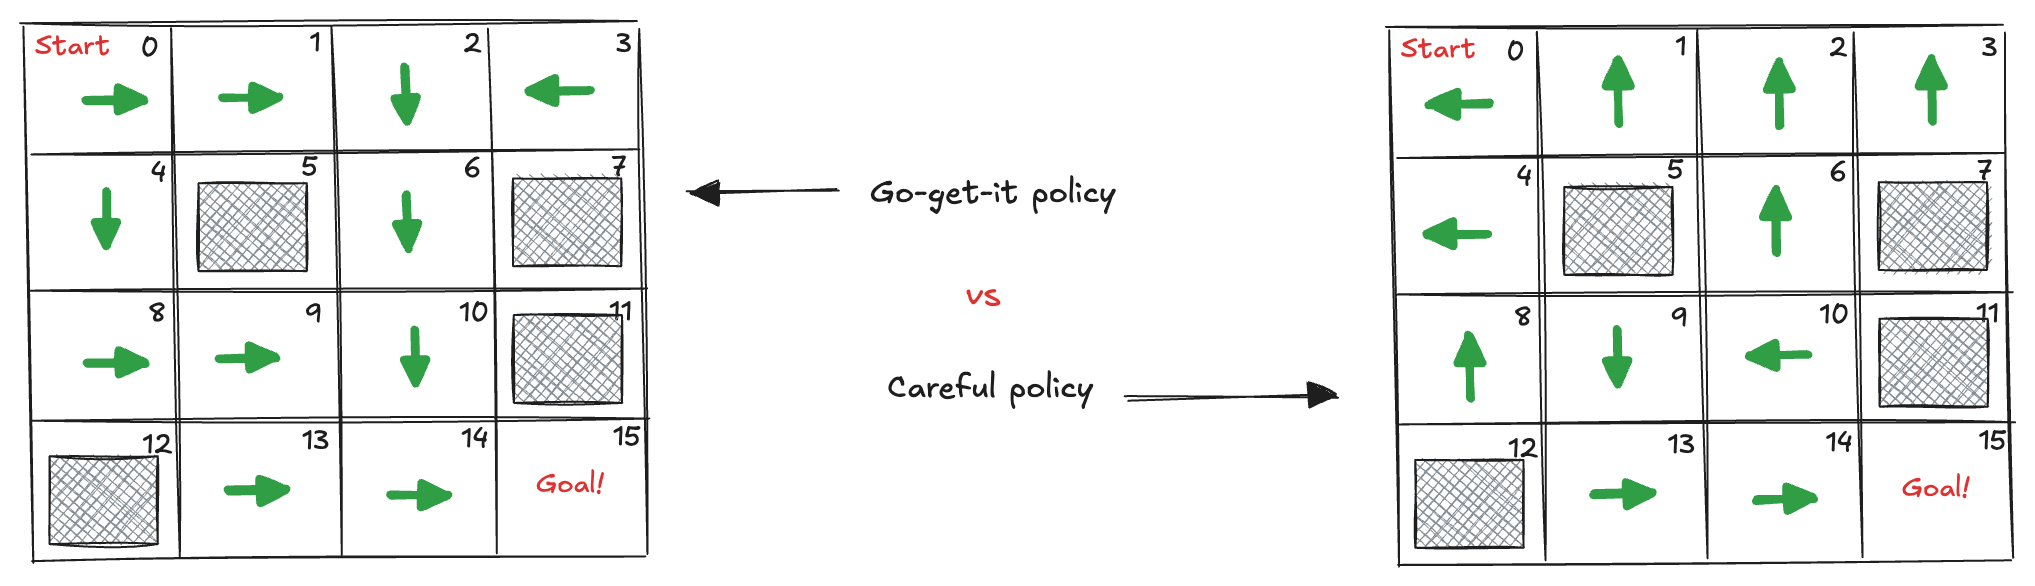

In order to compare the policies, we can use a brute-force approach. We simulate the environment for a long time and then we average the returns and evaluate the success probability. We ca use Gymnasium to simulate the environment. Notice that it wrap the environment using a single class, called Env. This class exposes the common most essential methods of any environment (like step and reset). Having this interface class is great, because it allows our code to be environment agnostic.

In [5]:
import numpy as np

def evaluate(env, pi, n_episodes=10000):
    success = 0;
    returns = [];

    for _ in range(n_episodes):
        done = False;    
        state, info = env.reset();
        returns.append(0.0)
        while not done:
            state, reward, terminated, truncated, info = env.step(pi(state));
            if(terminated or truncated):
                done = True;
            returns[-1] += reward;
        if(state == 15):
            success += 1;
    return (success/n_episodes)*100, np.mean(returns);

Notice that we need to take into account the possibility that the interaction never ends, becouse the stochasticity of the environment. In order to avoid this, he Gymnasium environment use a truncation condition (typically, a timelimit) to end an episode prematurely before a terminal state is reached. Now we can implement the Go-get-it policy and estimate its expected return on the FrozenLake environment::

In [6]:
LEFT, DOWN, RIGHT, UP = range(4)

go_get_pi = lambda s: {
    0:RIGHT, 1:RIGHT, 2:DOWN, 3:LEFT,
    4:DOWN, 5:LEFT, 6:DOWN, 7:LEFT,
    8:RIGHT, 9:RIGHT, 10:DOWN, 11:LEFT,
    12:LEFT, 13:RIGHT, 14:RIGHT, 15:LEFT
}[s]

In [7]:
import gymnasium as gym

frozen_lake = gym.make('FrozenLake-v1')

probability_success, mean_return = evaluate(frozen_lake, go_get_pi);
print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  3.44 %
Obtains an average undiscounted return of  0.0344


We simulate also the Careful policy:

In [8]:
careful_pi = lambda s: {
    0:LEFT, 1:UP, 2:UP, 3:UP,
    4:LEFT, 5:LEFT, 6:UP, 7:LEFT,
    8:UP, 9:DOWN, 10:LEFT, 11:LEFT,
    12:LEFT, 13:RIGHT, 14:RIGHT, 15:LEFT
}[s]

In [9]:
probability_success, mean_return = evaluate(frozen_lake, careful_pi);
print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  55.230000000000004 %
Obtains an average undiscounted return of  0.5523


It seems that Go-get-it policy doesn’t pay well in the FL environment! However, the brute-force approach is not a good idea for estimating the expected return, because it is very inefficient. We need a better way to evaluate policies.

## State-value function

We can associate a value of goodness to each state for a given policy. This can be useful to make decisions. For example, we can select the action that leads to the state with the highest value. In order to do this, we can calculate the expected return starting from every single state. This is called the **state-value function (or V-function)** denoted $v_\pi(s)$:

$\displaystyle v_{\pi}(s)=E_{\pi}(G_t|S_t=s)$

Notice that we are under stochastic environments, so we must account for all the possible ways the environment can react to a policy, so we need the expectation. For example, if we follow the Go-get-it policy starting from state 14, we get the following value:

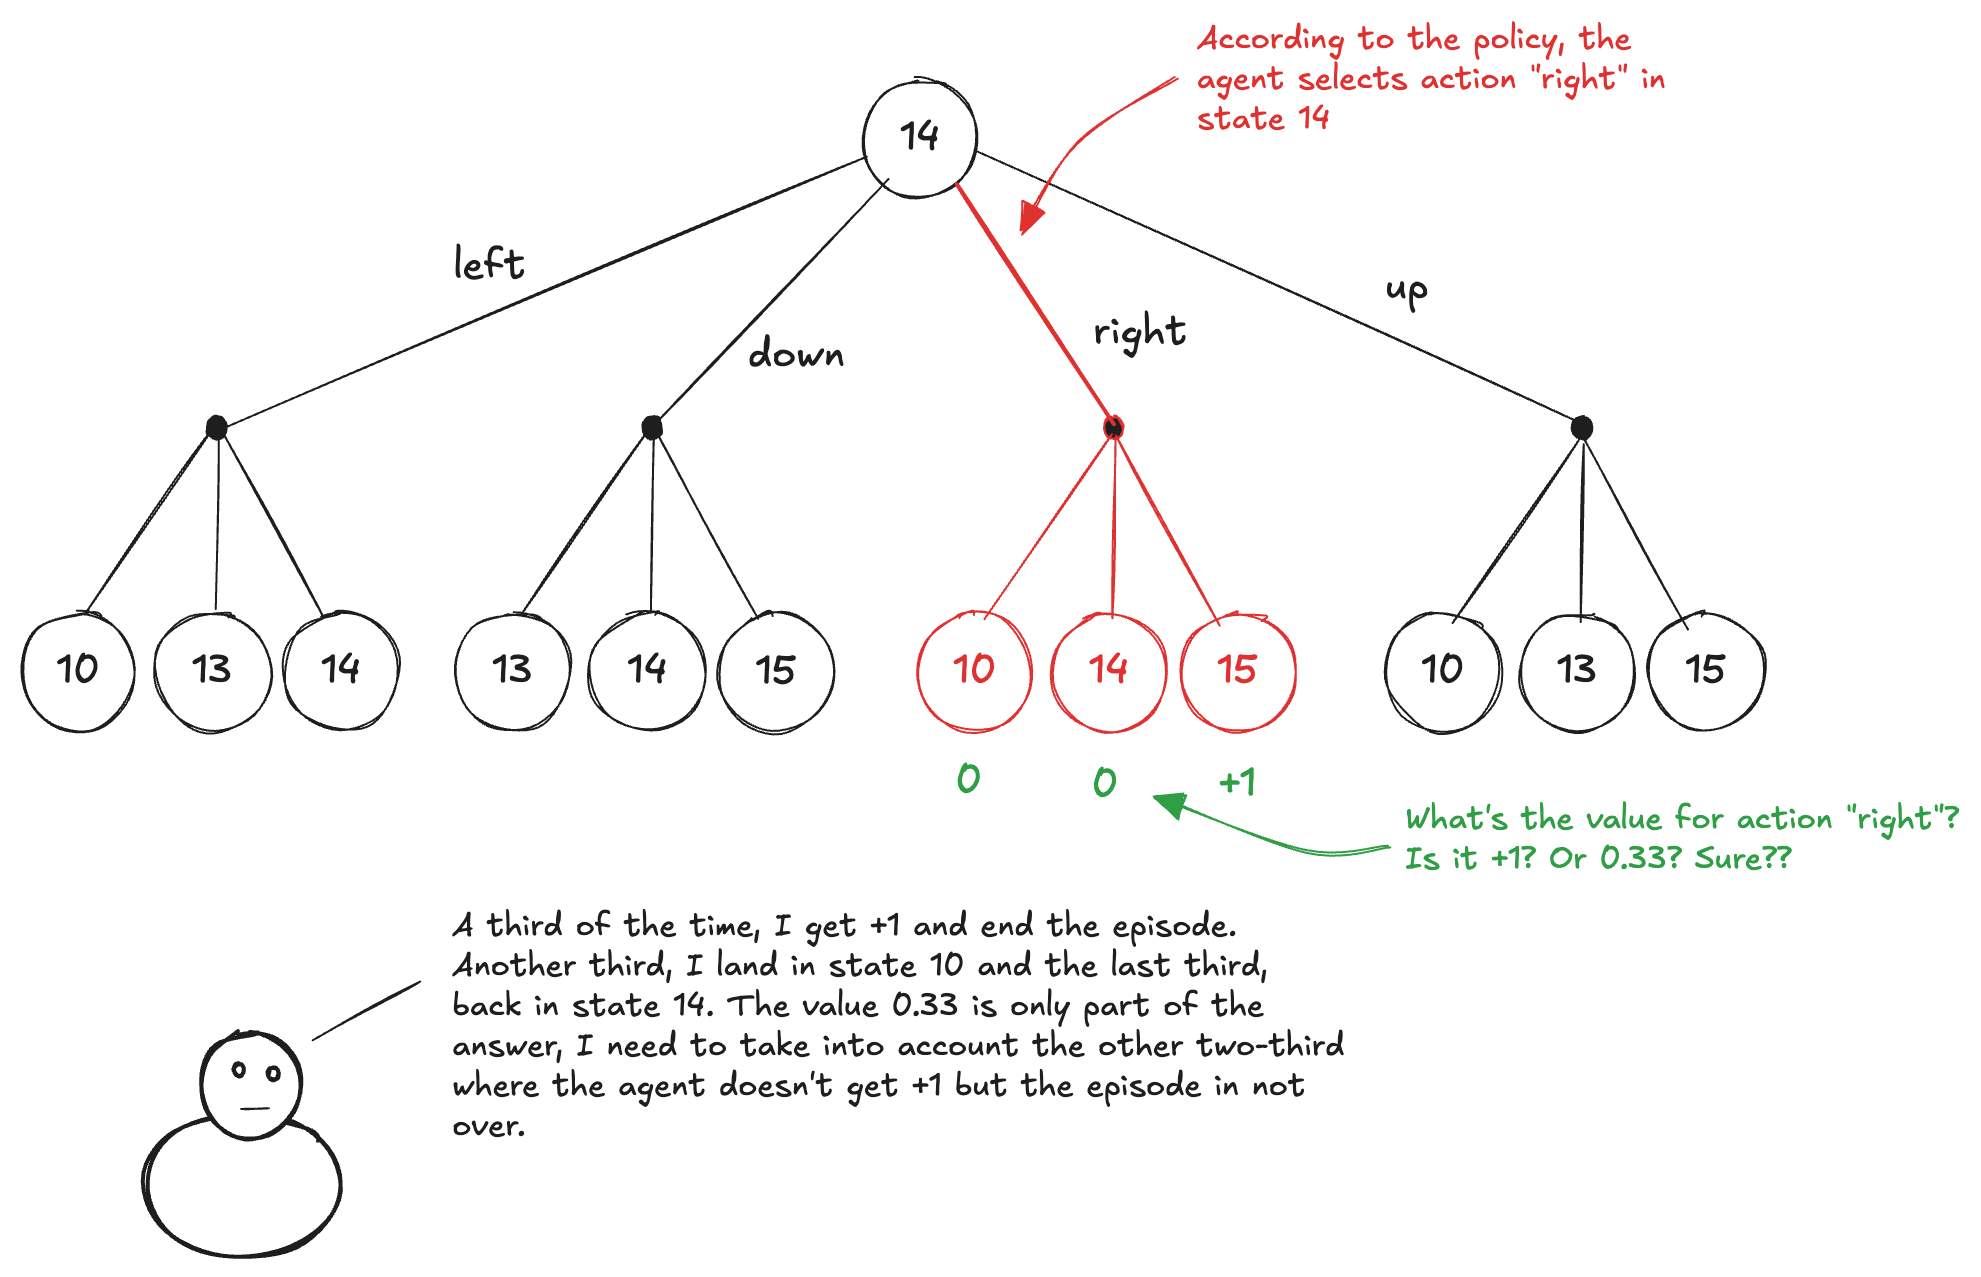

It isn’t straightforward to calculate, because of the dependence on the values of other states (10 and 14, in this case), which we don’t have either and one is the same state!

We can use the recursive definition of the return:

$\displaystyle v_{\pi}(s)=E_{\pi}(R_{t+1}+\gamma G_{t+1}|S_t=s)=$

applying the law of [total expectation](https://en.wikipedia.org/wiki/Law_of_total_expectation):

$\displaystyle =\sum\limits_{a}{\pi(a|s)} \left(E_{\pi}(R_{t+1}+\gamma G_{t+1}|S_t=s, A_t=a\right)=$

then splitting the expectation of a sum into a sum of expectations and note that, given an action, the expected immediate reward doesn't depend on the policy:

$\displaystyle =\sum\limits_{a}{\pi(a|s)} \left(E(R_{t+1}|S_t=s, A_t=a)+\gamma E_{\pi}(G_{t+1}|S_t=s, A_t=a)\right)=$

we can write the expected immediate reward in terms of the system dynamics:

$\displaystyle =\sum\limits_{a}{\pi(a|s)}\left(\sum\limits_{r}{r\sum\limits_{s'}{p(s',r|s,a)}}+\gamma E_{\pi}(G_{t+1}|S_t=s, A_t=a)\right)=$

applying the law of total expectation on the next state:

$\displaystyle =\sum\limits_{a}{\pi(a|s)}\left( \sum\limits_{s',r}{p(s',r|s,a)}r+\gamma \sum\limits_{s',r}{p(s',r|s,a)E_{\pi}(G_{t+1}|S_t=s, A_t=a, S_{t+1}=s')} \right) =$

by the Markov property, knowing $S_{t+1}$ makes the expectation independent of $S_t$ and $A_t$:

$\displaystyle = \sum\limits_{a}{\pi(a|s)}\left( \sum\limits_{s',r}{p(s',r|s,a)}r+\gamma \sum\limits_{s',r}{p(s',r|s,a)E_{\pi}(G_{t+1}|S_{t+1}=s')} \right) =$

acknowledging that 

$\displaystyle E_{\pi}(G_{t+1}|S_{t+1}=s')=v_{\pi}(s')$ 

and combining summations we obtain **the Bellman equation**:

$\displaystyle v_{\pi}(s)=\sum\limits_{a}{\pi(a|s)} \sum\limits_{s',r}{p(s',r|s,a)}(r+\gamma v_{\pi}(s'))$

The value of a state must equal the (discounted) value of the expected next state, plus the reward expected along the way:

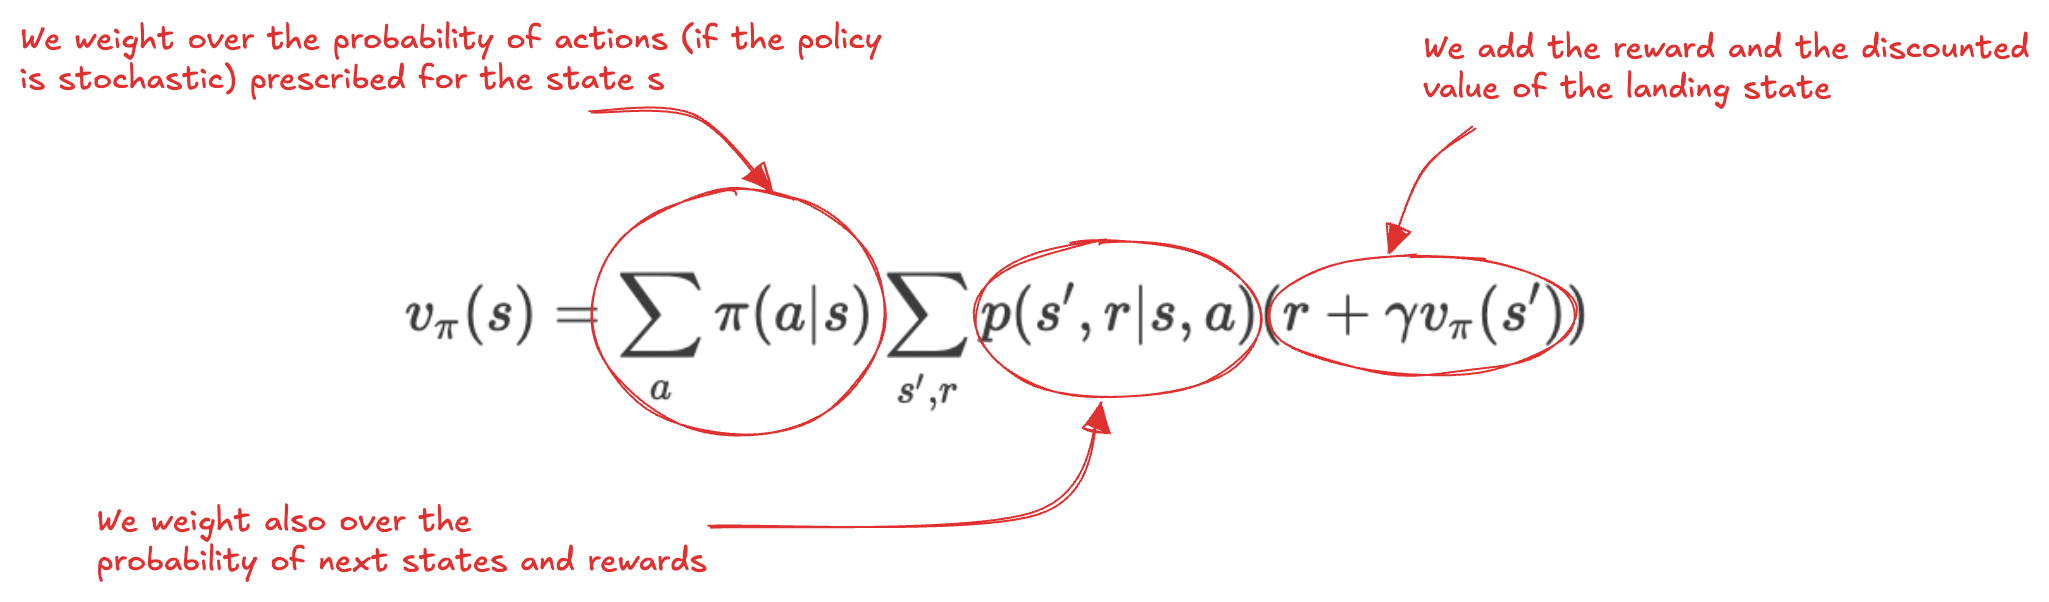

Notice how the value of a state depends recursively on the value of possibly many other states, which values may also depend on others, including the original state!

## Action-value function

The critical question is not merely about the value of a state, but the value of taking an action in a state. The **action-value function (or Q-function)** captures precisely this, the expected return if the agent follows a policy after taking an action in a state:

$\displaystyle q_{\pi}(s,a)=E_{\pi}(G_t|S_t=s, A_t=a)$

With can provide a formulation of the Bellman equation also for the action-value function with similar reasoning:

$\displaystyle q_{\pi}(s,a)=\sum\limits_{s',r}{p(s',r|s,a)}(r+\gamma \sum\limits_{a'}\pi(a'|s')q_{\pi}(s',a'))$

These value functions can be **estimated from experience**. For example, if an agent follows a policy and maintains an average (for each state encountered) of the actual returns that have followed that state, then the average will converge to the state value as the number of times that state is encountered approaches infinity. If separate averages are kept for each action taken in each state, then these averages will similarly converge to the action values. Of course, if there are many states, then it may not be practical to keep separate averages for each state or action individually, instead, the agent can maintain parameterized esteems (with fewer parameters than states) and adjust the parameters to better match the observed returns. 

## Optimal Policies

Policies, state-value functions and action-value functions are the components we use to describe, evaluate, and improve behaviors. We call it **optimality** when these components are the best they can be. Solving a reinforcement learning task means, roughly, finding a policy that achieves a lot of reward over the long run. Value functions define an ordering over policies. A policy is defined to be better than or equal to a policy if its expected return is greater than or equal for all states:

$\displaystyle \pi >= \pi' \quad \Leftrightarrow \quad v_{\pi}>=v_{\pi'} \quad \forall s \in S$

There is always at least one policy that is better than or equal to all other policies. This is an **optimal policy**.

$\displaystyle \pi_* >= \pi \quad \forall \pi$

Similarly, an **optimal state-value function** is a state-value function with the maximum value across all policies for all states:

$\displaystyle v_*(s)=\underset{\pi }{\text{max }}v_{\pi}(s) \quad \forall s \in S$

Finally, an **optimal action-value function** is an action-value function with the maximum value across all policies for all state-action pairs. 

$\displaystyle q_*(s,a)=\underset{\pi }{\text{max }}q_{\pi}(s,a) \quad \forall s \in S \quad \forall a \in A$

Notice that if we had the optimal state-value function, we could use the MDP to do a one-step search for the optimal action-value function:

$\displaystyle q_*(s,a)= E(R_{t+1} + \gamma v_*(S_{t+1}) | S_t=s, A_t=a)$

And if we had the optimal action-value function, we don’t need the MDP at all. We can use it to find the optimal state-value function by merely taking the maximum over the actions:

$\displaystyle v_*(s)=\underset{a}{\text{max }}q_*(s,a)$

Then, we can write:

$\displaystyle v_*(s)=\underset{a}{\text{max }}E(R_{t+1}+\gamma v_*(S_{t+1})|S_t=s, A_t=a)$

$\displaystyle = \underset{a}{\text{max }} \sum\limits_{s',r}{p(s',r|s,a)}[r+\gamma v_*(s')]$

This means that we take the max action of the weighted sum of the reward and discounted optimal value of the next state.

Similarly, the optimal action-value function can be obtained this way:

$\displaystyle q_*(s,a)= \sum\limits_{s',r}{p(s',r|s,a)}[r+\gamma \underset{a'}{\text{max }} q_*(s',a')]$

These equations are called the **Bellman optimality equations** and they are a system of equations and if the dynamic of the environment is known, then in principle we can solve it. Once one has one of them, it is easy to determine an optimal policy. This solution relies on at least three assumptions that are rarely true in practice: 

- we accurately know the dynamics of the environment;  
- we have enough computational resources to complete the computation of the solution; 
- the Markov property.  

Generally various combinations of these assumptions are violated and in reinforcement learning typically we have to settle for approximate solutions.

## Policy Evaluation

In order to search for good policies, we need an algorithm for evaluating an arbitrary policy more efficiently than the brute-force approach. Such an algorithm is known as a **policy evaluation** and consists of calculating the state-value function for a given policy by sweeping through the state space and iteratively improving estimates. The initial approximation is chosen arbitrarily and each successive approximation is obtained by using the Bellman equation as an **update rule**:

$\displaystyle v_{k+1}(s)=E_{\pi}(R_{t+1} + \gamma v_k(S_{t+1}|S_t=s))=\sum\limits_{a}{\pi(a|s)}( \sum\limits_{s',r}{p(s',r|s,a)}(r+\gamma v_{k}(s')))$

this sequence can be shown to converge to the value function as k goes to infinity, under the same conditions that guarantee the existence of the value function. To produce each successive approximation, we apply the same operation to each state: we replace the old value of state with a new value obtained from the old values of the successor of the state and the expected immediate rewards, along all the one-step transitions possible under the policy being evaluated. 

Note that update estimates of the values of states are based on estimates of the values of successor states. That is, they **update estimates on the basis of other estimates**. We call this general idea **bootstrapping**.

Formally, the iterative policy evaluation converges only in the limit, but in practice it must be halted short. For example, we can tests the quantity:

$\displaystyle \underset{s \in S}{\text{max }}|v_{k+1}(s)−v_k(s)|$ 

and stops the interative process when it is sufficiently small.

The same update rule can be alo applied to the action-value function:

$\displaystyle q_{k+1}(s,a)=\sum\limits_{s',r}{p(s',r|s,a)}(r+\gamma \sum\limits_{a'}\pi(a'|s')q_{k}(s',a')$

It’s important to notice that k here indicates **iterations across estimates**, and they’re **not interactions with the environment**. These aren’t episodes, and the agent isn't selecting actions and observing the environment. These aren’t time steps either. Instead, these are the iterations of the iterative policy evaluation algorithm.

We can write the policy evaluation algorithms in Python:

In [6]:
# We need the policy to evaluate and the MDP the policy runs on 
# The discount factor and gamma are defaults to 1
# Theta is a small number that we use to check for convergence

def policy_evaluation(pi, env, gamma=1.0, theta=1e-10):
    
    # we need to unwrap the environment to access its 
    # internal dynamic
    dynamics = env.unwrapped.P;

    # initialize the first-iteration estimates to zero
    prev_v = np.zeros(len(dynamics));
    
    # looping forever...
    while True:
        # initialize the current-iteration estimates to zero as well
        v = np.zeros(len(dynamics));
        
        # loop through all states to estimate the state-value function
        for s in range(len(dynamics)):
            
            # we use the policy pi to get the possible transitions
            for prob, next_state, reward, done in dynamics[s][pi(s)]:
                
                # estimate the value of that state using the update rule
                v[s] += prob * (reward + gamma * prev_v[next_state]);
        
        # check for the stopping condition
        if np.max(np.abs(prev_v - v)) < theta:
            break;
        
        # finally, copy to get ready for the next iteration
        prev_v = v.copy()
        
    # return the latest state-value function    
    return v

We can write a simple function to print the value function in a readable way:

In [9]:
def print_state_value_function(v, env):
    dynamics = env.unwrapped.P;
    n_cols = 4;
    print("State-value function:");
    for s in range(len(dynamics)):
        if np.all([done for action in dynamics[s].values() for _, _, _, done in action]):
            print(" X  ", end="\t");
        else:
            print(np.round(v[s], 2), end="\t");
        if (s+1)%n_cols==0: 
            print(" ");

Let’s now run policy evaluation for the two policies Go-get-it and Careful for the Frozen Lake environment. We need to get the unwrapped environment in order to access the dynamics:

In [10]:
v = policy_evaluation(go_get_pi, frozen_lake, gamma=0.99)
print_state_value_function(v, frozen_lake)

State-value function:
0.03	0.02	0.05	0.02	 
0.05	 X  	0.1	 X  	 
0.09	0.24	0.29	 X  	 
 X  	0.43	0.64	 X  	 


In [11]:
v = policy_evaluation(careful_pi, frozen_lake, gamma=0.99)
print_state_value_function(v, frozen_lake)

State-value function:
0.41	0.38	0.35	0.34	 
0.42	 X  	0.12	 X  	 
0.45	0.48	0.43	 X  	 
 X  	0.59	0.71	 X  	 


As already seen, the Go-get-it policy doesn’t pay well in this environment! Whereas the Careful policy is much better. Fascinating results, but a question arises: are there any better policies?

## Policy Improvement

The reason for computing the value function for a policy is to help in finding better policies. Suppose we have determined the value function for a policy. For a state, we would like to know if we should change the policy and choose an action different from the one prescribed by the policy (in other word following a different policy). We know how good is to follow the current policy (it is given by the value function), but would it be better to change? One way to answer this question is to consider selecting the different action, thereafter following the existing policy and calculte the value function under this assumption. Then, it this value is greater, it is better to select the new action in that state than following the policy. This is a case of the general **policy improvement theorem**, Let's indicate with $\pi$ the current policy and with $\pi'$ the new one:

$\displaystyle q_{\pi}(s,\pi'(s)) \geq v_{\pi}(s) \enspace \forall s \in S \quad \Rightarrow \quad v_{\pi'}(s) \geq v_{\pi}(s)$

This result applies to the two policies that we considered before. The original policy and a changed policy that is identical to the first, except for the different action taken in one state. Thus, $q_{\pi}(s, a) > v_{\pi}(s)$, then the changed policy is indeed better than the original one. It is natural to extend this and to consider changes at all states and to all possible actions, selecting at each state the action that appears best according to $q_{\pi}(s, a)$:

$\displaystyle \pi'(s) = \underset{a}{\arg \max}\> q_{\pi}(s,a) = \underset{a}{\arg \max}\> \sum\limits_{s',r}{p(s',r|s,a)}(r+\gamma v_{\pi}(s'))$

The process of making a new policy that improves an original policy, by making it greedy with respect to the value function of the original policy, is called **policy improvement**. Let's try to improve the Careful policy: if we act greedily with respect to the value function of the policy, we obtain a new Careful+ policy:

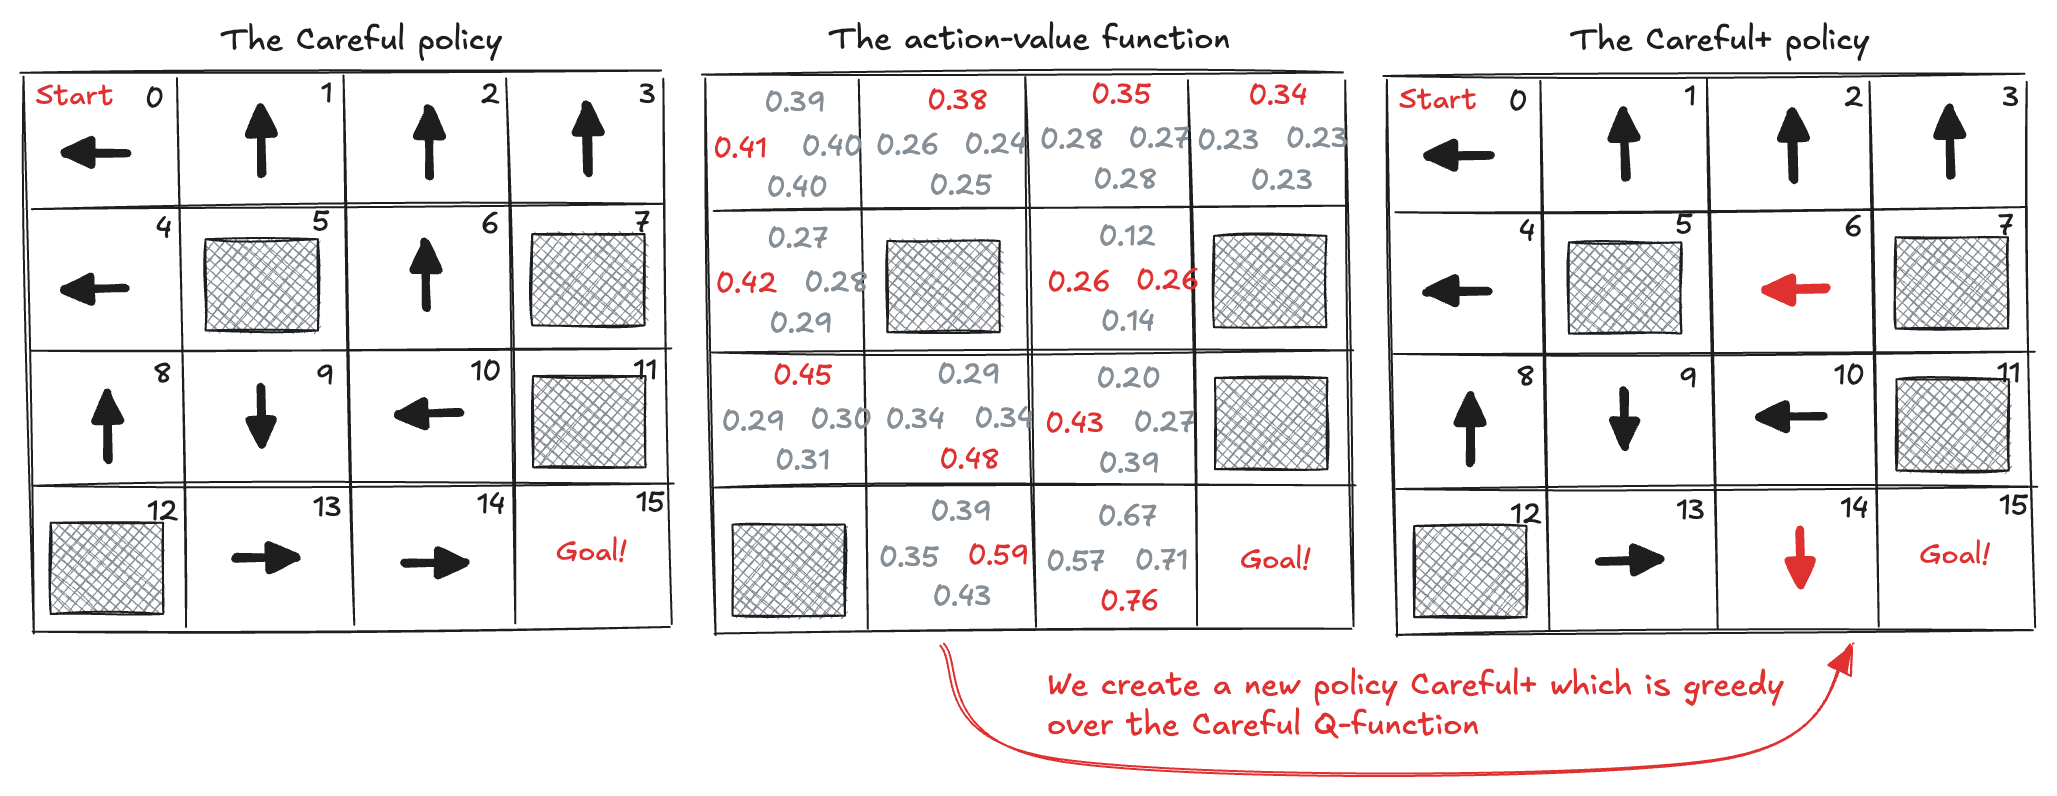

Let's implement it in Python:

In [12]:
# It takes the state-value function of the policy
# we want to improve and the environment
def policy_improvement(v, env, gamma=1.0):

    # we need to unwrap the environment to access its 
    # internal dynamic
    dynamics = env.unwrapped.P;
    
    # initialize the Q-function to zero
    q = np.zeros((len(dynamics), len(dynamics[0])))
    
    # loop through the states, actions, and transitions...
    for s in range(len(dynamics)):
        for a in range(len(dynamics[s])):
            for prob, next_state, reward, done in dynamics[s][a]:
                # ...and calculate the action-value function
                q[s][a] += prob * (reward + gamma * v[next_state])
                
    # obtain a new, greedy policy by taking the argmax of the Q-function            
    def new_pi(s):
        return np.argmax(q[s])
    
    return new_pi;

We can create a support function in order to visualize policies:

In [13]:
def print_policy(pi, env):
    dynamics = env.unwrapped.P;
    actions = [' < ', ' v ', ' > ', ' ^ ', '   '];
    n_cols = 4;
    print("Policy:");
    for s in range(len(dynamics)):
        if np.all([done for action in dynamics[s].values() for _, _, _, done in action]):
            print(" X  ", end="\t");
        else:    
            print(actions[pi(s)], end="\t");
        if (s+1)%n_cols==0: 
            print(" ");

Then we can try to improve the careful policy:

In [14]:
careful_plus_pi = policy_improvement(v, frozen_lake, gamma=0.99)
print_policy(careful_plus_pi, frozen_lake);

Policy:
 < 	 ^ 	 ^ 	 ^ 	 
 < 	 X  	 < 	 X  	 
 ^ 	 v 	 < 	 X  	 
 X  	 > 	 v 	 X  	 


Is this policy any better? Well, we can evaluate it with brute-force or using the policy evaluation algorithm:

In [15]:
probability_success, mean_return = evaluate(frozen_lake, 
                                            careful_plus_pi);
print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  73.81 %
Obtains an average undiscounted return of  0.7381


As we can see, the Careful+ can reach the goal state with a much better probability than the Careful policy. This is a good example of how the policy improvement theorem works. We can also check the difference between the state-value functions of the two policies:

In [16]:
v_plus = policy_evaluation(careful_plus_pi, frozen_lake, gamma=0.99);
print_state_value_function(v_plus, frozen_lake);

State-value function:
0.54	0.5	0.47	0.46	 
0.56	 X  	0.36	 X  	 
0.59	0.64	0.62	 X  	 
 X  	0.74	0.86	 X  	 


In [17]:
difference = v_plus - v;
print_state_value_function(difference, frozen_lake);

State-value function:
0.13	0.12	0.12	0.11	 
0.14	 X  	0.24	 X  	 
0.15	0.16	0.18	 X  	 
 X  	0.15	0.15	 X  	 


The new policy is better than the original one. This is great, acting greedily with respect to the action-value function gave us an improved policy. This is what the policy-improvement algorithm does: **it calculates an action-value function using the current policy and the MDP, then it returns an improved policy acting greedy with respect to the action-value function of the original policy**. The natural next questions are these: is there a better policy than this one? Can we do any better than careful+? Can we evaluate the careful+ policy, and then improve it again?

In [18]:
careful_plus_plus_pi = policy_improvement(v_plus, frozen_lake, gamma=0.99)

In [19]:
print_policy(careful_plus_plus_pi, frozen_lake)

Policy:
 < 	 ^ 	 ^ 	 ^ 	 
 < 	 X  	 < 	 X  	 
 ^ 	 v 	 < 	 X  	 
 X  	 > 	 v 	 X  	 


In [20]:
probability_success, mean_return = evaluate(frozen_lake, 
                                            careful_plus_plus_pi);
print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  74.00999999999999 %
Obtains an average undiscounted return of  0.7401


There’s no improvement this time. No improvement occurs because the careful+ policy is an optimal policy of the Frozen Lake environment. We only needed one improvement over the careful policy because this policy was good to begin with. However, even if we start with an **adversarial policy** (designed to perform poorly) **alternating over policy evaluation and improvement** would still end up with an optimal policy:

In [21]:
adversarial_pi = lambda s: {
    0:UP, 1:UP, 2:UP, 3:UP,
    4:UP, 5:LEFT, 6:UP, 7:LEFT,
    8:LEFT, 9:LEFT, 10:LEFT, 11:LEFT,
    12:LEFT, 13:LEFT, 14:LEFT, 15:LEFT
}[s]

In [22]:
print_policy(adversarial_pi, frozen_lake);

Policy:
 ^ 	 ^ 	 ^ 	 ^ 	 
 ^ 	 X  	 ^ 	 X  	 
 < 	 < 	 < 	 X  	 
 X  	 < 	 < 	 X  	 


In [23]:
probability_success, mean_return = evaluate(frozen_lake, 
                                            adversarial_pi);
print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  0.0 %
Obtains an average undiscounted return of  0.0


In [24]:
v_1 = policy_evaluation(adversarial_pi, frozen_lake, gamma=0.99)
adversarial_pi_2 = policy_improvement(v_1, frozen_lake, gamma=0.99)

v_2 = policy_evaluation(adversarial_pi_2, frozen_lake, gamma=0.99)
adversarial_pi_3 = policy_improvement(v_2, frozen_lake, gamma=0.99)

v_3 = policy_evaluation(adversarial_pi_3, frozen_lake, gamma=0.99)
adversarial_pi_4 = policy_improvement(v_3, frozen_lake, gamma=0.99)

v_4 = policy_evaluation(adversarial_pi_4, frozen_lake, gamma=0.99)
adversarial_pi_5 = policy_improvement(v_4, frozen_lake, gamma=0.99)

In [25]:
print_policy(adversarial_pi_5, frozen_lake)

Policy:
 < 	 ^ 	 > 	 ^ 	 
 < 	 X  	 < 	 X  	 
 ^ 	 v 	 < 	 X  	 
 X  	 > 	 v 	 X  	 


In [26]:
probability_success, mean_return = evaluate(frozen_lake, 
                                            adversarial_pi_5);
print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  71.93 %
Obtains an average undiscounted return of  0.7193


## Policy Iteration

Once a policy has been improved using its value function to yield a better policy, we can then compute a new value function and improve again to yield an even better policy. We can thus obtain a sequence of monotonically improving policies and value functions:

$\displaystyle \pi_0 \overset{evaluate}{\longrightarrow }  v_{\pi_0} \overset{improve}{\longrightarrow } \pi_1 \overset{evaluate}{\longrightarrow }  v_{\pi_1} \overset{improve}{\longrightarrow } \pi_2 \overset{evaluate}{\longrightarrow } ... \overset{improve}{\longrightarrow } \pi_* \overset{evaluate}{\longrightarrow }  v_{\pi_*}$ 

Each policy is guaranteed to be a strict improvement over the previous one (unless it is already optimal). Because a finite MDP has only a finite number of policies, this process must converge to an optimal policy in a finite number of iterations. This way of finding an optimal policy is called **policy iteration**. We can put all toghether in Python:

In [49]:
# it only needs the MDP (including gamma)
def policy_iteration(env, gamma=1.0, theta=1e-10):

    # we need to unwrap the environment to access its 
    # internal dynamic
    dynamics = env.unwrapped.P;
    
    # create a starting random policy: 
    def pi(s):
        return np.random.choice(tuple(dynamics[0].keys()));
    
    while True:        
        # get the state-value function of the policy
        v = policy_evaluation(pi, env, gamma, theta)
        
        # get an improved policy
        new_pi = policy_improvement(v, env, gamma)
        
        # if it’s different, we do it all over again
        if np.all([pi(s) == new_pi(s) for s in range(len(dynamics))]):
            break;

        pi = new_pi;
    
    # if it’s not, we break out of the loop and return 
    # the optimal policy and the optimal state-value function 
    return v, new_pi

Let’s try it:

In [50]:
v_best, pi_best = policy_iteration(frozen_lake, gamma=0.99)

In [51]:
print_policy(pi_best, frozen_lake)

Policy:
 < 	 ^ 	 ^ 	 ^ 	 
 < 	 X  	 < 	 X  	 
 ^ 	 v 	 < 	 X  	 
 X  	 > 	 v 	 X  	 


In [52]:
print_state_value_function(v_best, frozen_lake)

State-value function:
0.54	0.5	0.47	0.46	 
0.56	 X  	0.36	 X  	 
0.59	0.64	0.62	 X  	 
 X  	0.74	0.86	 X  	 


In [53]:
probability_success, mean_return = evaluate(frozen_lake, 
                                            pi_best);
print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  74.11999999999999 %
Obtains an average undiscounted return of  0.7412


As expected, alternating policy evaluation and policy improvement yields an optimal policy and the optimal state-value function, regardless of the policy we start with.  Notice how we use "an" optimal policy, but also use "the" optimal state-value function. This is not a coincidence, this is a property: an MDP can have more than one optimal policy, but it can only have a single optimal state-value function. A state-value function may have actions that are equally valued for a given state, in this case, there could be multiple optimal policies, each optimal policy selecting a different, but equally valued, action. Take a look at the Fronzen Lake example:

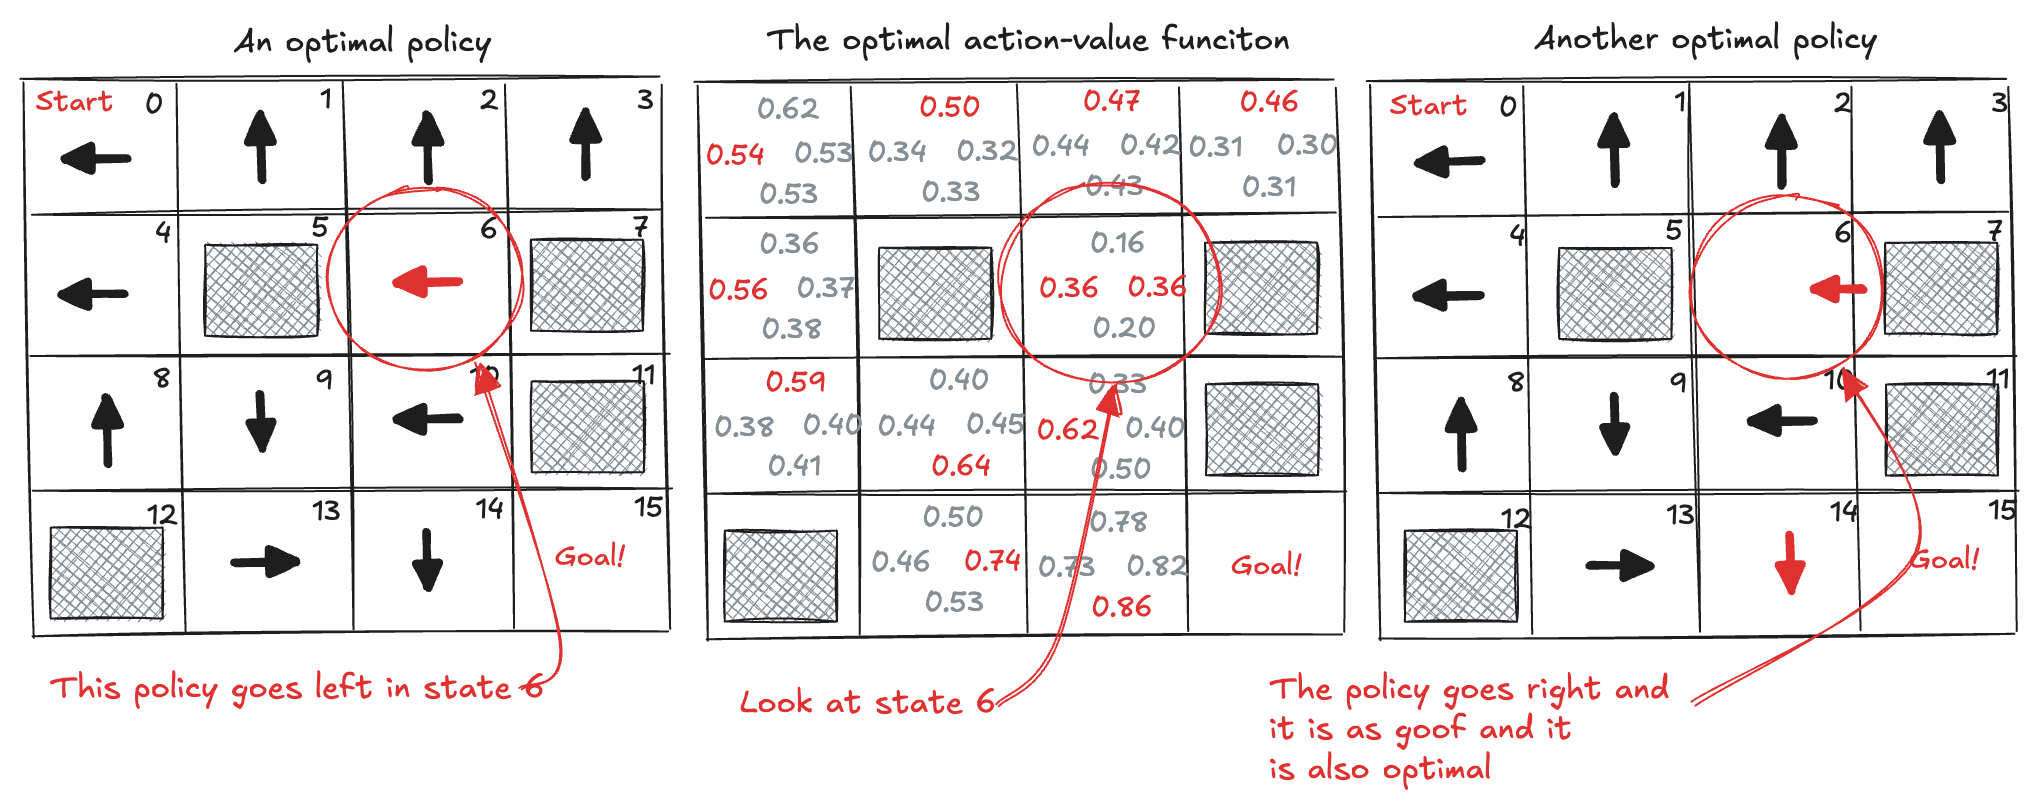

So far we have considered the special case of deterministic policies, anyway all the ideas extend easily to stochastic policies. In particular, if there are several actions at which the maximum is achieved, in the stochastic case we need not select a single action from among them. Instead, each maximizing action can be given a portion of the probability of being selected in the new greedy policy.

## Value Iteration

Policy interaction works, but **it is really slow**. Each of its iterations involves policy evaluation, which is a protracted iterative computation requiring multiple sweeps through the state set. However, if we truncated policy evaluation after a single iteration, we could still improve the policy by taking a new policy greedy with the action-value function estimation after a single state-space sweep of policy evaluation. This algorithm is called **value iteration**.  It can be thought of "greedily greedifying policies", because we calculate the greedy policy as soon as we can, greedily. Value iteration **doesn’t wait until we have an accurate estimate of the policy before improving it, but instead, it truncates the policy-evaluation phase after a single state sweep**. We can merge a truncated policy-evaluation step and a policy improvement step into the same equation. Instead of improving the policy (by taking the argmax to get a better policy and then evaluating this improved policy to obtain a value function again), we directly calculate the maximum (max, instead of argmax) value across the actions to be used for the next sweep over the states:

$\displaystyle v_{k+1}(s) = \underset{a}{\max}\> \sum\limits_{s',r}{p(s',r|s,a)}(r+\gamma v_{k}(s')) = \underset{a}{\max}\> q_{k}(s',a)$

For arbitrary intial value function, the sequence of improved value function converges to the optimal one under the same conditions that guarantee the existence of the optimal function. Like policy evaluation, value iteration formally requires an infinite number of iterations to converge. In practice, we stop the interative process once the value function changes by only a small amount in a sweep.

Notice that in practice, in value iteration, **we don’t have to deal with policies at all**. It doesn’t have any separate evaluation phase that runs to convergence. While the goal is the same as of policy iteration (to find the optimal policy), it happens to do this through the value functions (thus the name). Only at the end of the algorithm, after the value function converges to the optimal, we will extract the optimal policy by taking the argmax over the actions of the action-value function, as before. We can implement this algorithm in Python: 

In [39]:
def value_iteration(env, gamma=1.0, theta=1e-10):

    # we need to unwrap the environment to access its 
    # internal dynamic
    dynamics = env.unwrapped.P;
    
    # initialize a state-value function
    v = np.zeros(len(dynamics))
    
    while True:
        q = np.zeros((len(dynamics), len(dynamics[0])))
        
        # for every transition of every action in every state, we...
        for s in range(len(dynamics)):
            for a in range(len(dynamics[s])):
                for prob, next_state, reward, done in dynamics[s][a]:    
                    # ...calculate the action-value function
                    q[s][a] += prob * (reward + gamma * v[next_state])
        
        # After each sweep over the state space, make sure the state-value function keeps changing, 
        # otherwise, we found the optimal state-value function and should break out
        if np.max(np.abs(v - np.max(q, axis=1))) < theta:
            break;
            
        # we don’t need a separate policy-improvement phase
        v = np.max(q, axis=1)
    
    # only at the end, we extract the optimal policy
    def pi(s): 
        return np.argmax(q[s])  
    
    return v, pi

And again, we can solve the Frozen Lake problem:

In [40]:
v_best, pi_best = value_iteration(frozen_lake, gamma=1)

In [41]:
print_policy(pi_best, frozen_lake)

Policy:
 < 	 ^ 	 ^ 	 ^ 	 
 < 	 X  	 < 	 X  	 
 ^ 	 v 	 < 	 X  	 
 X  	 > 	 v 	 X  	 


In [174]:
print_state_value_function(v_best, frozen_lake)

State-value function:
0.54	0.5	0.47	0.46	 
0.56	 X  	0.36	 X  	 
0.59	0.64	0.62	 X  	 
 X  	0.74	0.86	 X  	 


In [176]:
probability_success, mean_return = evaluate(frozen_lake, 
                                            pi_best);
print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  73.88 %
Obtains an average undiscounted return of  0.7388


Let solve the problem also for the no discounting case ($\gamma = 1$) and for a different discounting value ($\gamma = 0.95$):

In [184]:
v_best_no_discounting, _ = value_iteration(frozen_lake, gamma=1.00)
print_state_value_function(v_best_no_discounting, frozen_lake)

State-value function:
0.82	0.82	0.82	0.82	 
0.82	 X  	0.53	 X  	 
0.82	0.82	0.76	 X  	 
 X  	0.88	0.94	 X  	 


In [185]:
v_best_different_discounting, _ = value_iteration(frozen_lake, gamma=0.95)
print_state_value_function(v_best_different_discounting, frozen_lake)

State-value function:
0.18	0.15	0.15	0.13	 
0.21	 X  	0.18	 X  	 
0.27	0.37	0.4	 X  	 
 X  	0.51	0.72	 X  	 


We find that they are not the same. Introducing discounting in a stochastic environment can either have no effect or **favor more risky but faster (less discounting) policies**. 

A major drawback of the dynamic programming methods is that they require a perfect model of the environment, these methods in a way **"cheat" because they require full access to the MDP**, which is something we can’t always obtain.  Another problem is that they **involve operations over the entire state set of the MDP**. If the state set is very large, then even a single sweep can be prohibitively expensive. For example, the game of backgammon has over $10^{20}$ states. **Asynchronous dynamic programming** are iterative algorithms that are not organized in terms of systematic sweeps of the state set, but they update values of states in any order. To converge correctly, however, they must continue to update the values of all the states. Of course, avoiding sweeps does not necessarily mean that we can get away with less computation. It just means that an algorithm does not need to get locked into any hopelessly long sweep before it can make progress improving a policy.

## Generalization

The dynamic programming approach consists of **two simultaneous, interacting processes, one making the value function consistent with the current policy (evaluation), and the other making the policy greedy with respect to the current value function (improvement)**. These two processes can alternate, each completing before the other begins (policy iteration); or only a single iteration of evaluation can be performed before each policy improvement; moreover, the evaluation and improvement can be interleaved at an even finer grain (asynchronous methods). As long as both processes continue to update all states, the ultimate result is typically the same: convergence to the optimal value function and an optimal policy. We use the term **generalized policy iteration** to refer to the **general idea of letting evaluation and improvement processes interact**, independently from the granularity and other details of the two processes. 

Almost all reinforcement learning methods are well described as generalized policy iteration approached: all have policies and value functions, with the policy always being improved with respect to the value function and the value function always being driven toward the policy. If both the processes stabilize (no longer produce changes), then the value function and policy must be optimal.  The evaluation and improvement processes can be viewed as both **competing and cooperating**. They compete in the sense that they pull in opposing directions. Making the policy greedy with respect to the value function typically makes the value function incorrect for the changed policy, and making the value function consistent with the policy typically causes that policy no longer to be greedy. In the long run, however, these two processes interact to find a single joint solution: the optimal value function and an optimal policy.

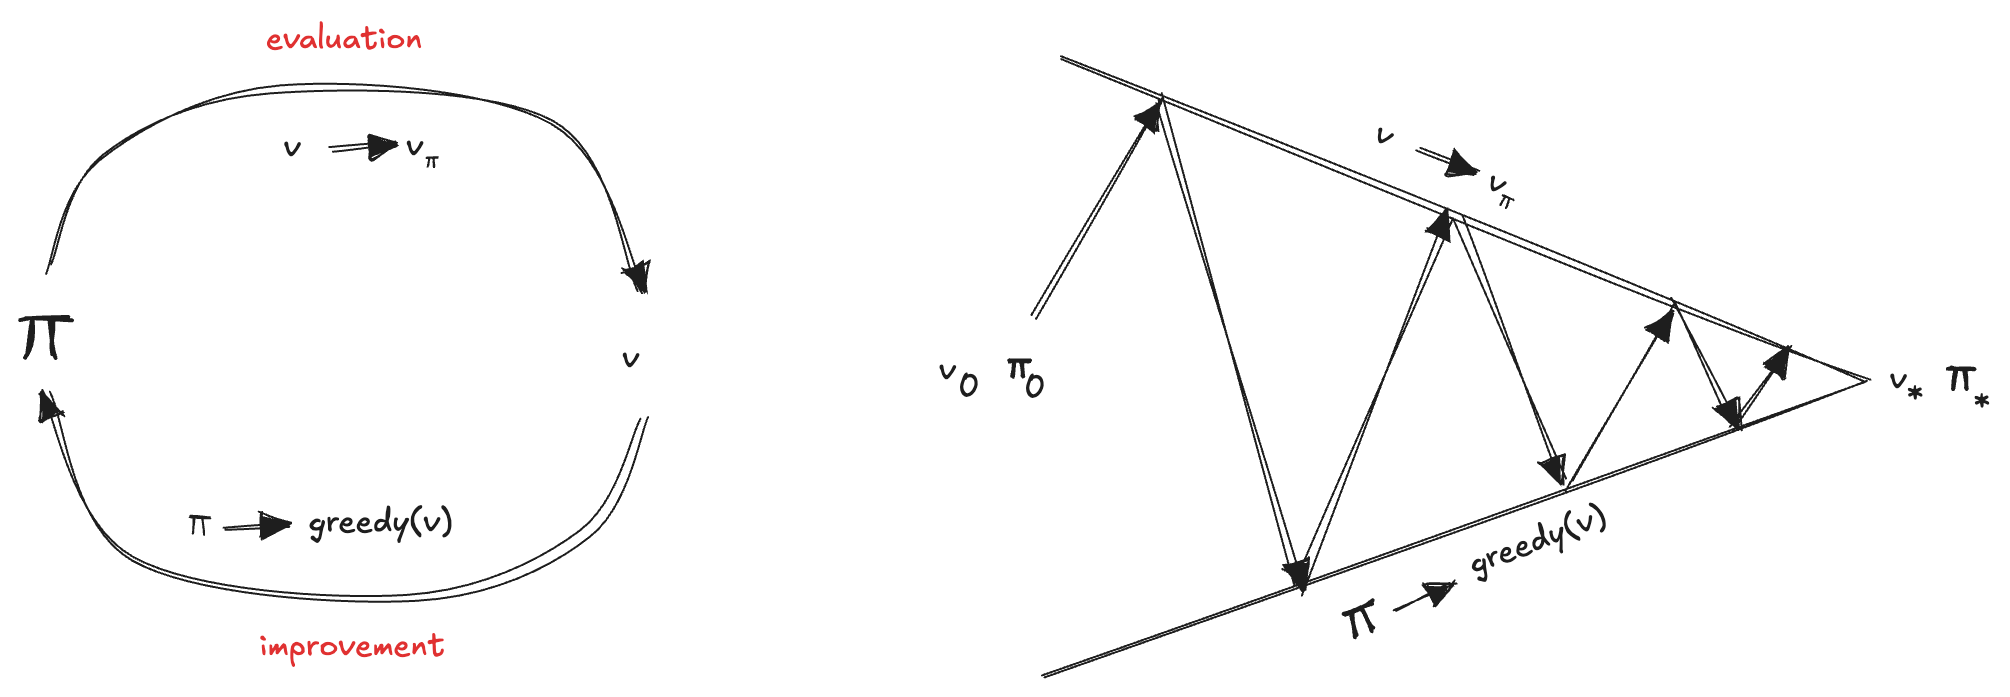